In [2]:
%load_ext autoreload
%autoreload 2
%cd ..

/media/minhduc0711/Libraries/Codes/EURECOM/MALIS_project


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from torchaudio import transforms
import librosa
import matplotlib.pyplot as plt

from src.data.midi import parse_midi
from src.data.data_modules import MAPSDataModule

In [61]:
sample_rate = 16000
n_mels = 229
hop_length = 512
n_fft = 2048

In [97]:
audio_path = "data/processed/MAPS_MUS/AkPnBsdf/MAPS_MUS-alb_se3_AkPnBsdf.wav"
wav, sr = torchaudio.load(audio_path)
wav = wav.mean(dim=0)

wav_16k = transforms.Resample(sr, new_freq=16000)(wav)
mel = transforms.MelSpectrogram(n_mels=229, hop_length=512, n_fft=2048)(wav_16k)
mel.shape

In [101]:
transforms.MelSpectrogram(n_mels=229, hop_length=512, n_fft=2048).hop_length

512

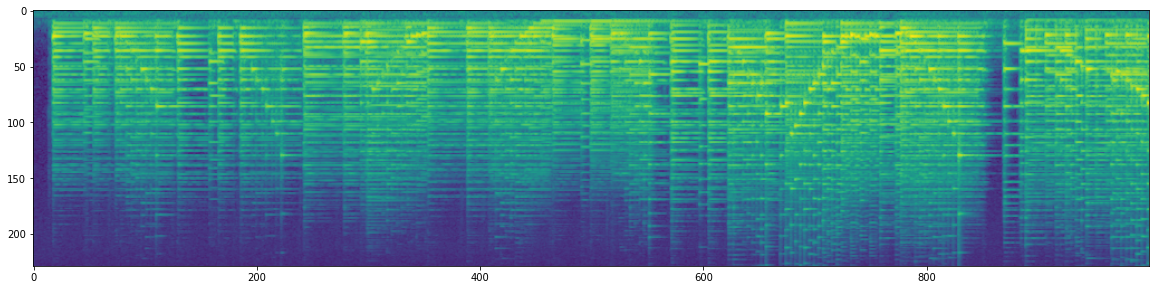

In [51]:
plt.figure(figsize=(20,20))
plt.imshow(mel.log2()[1,:,:1000].numpy())

In [79]:
# quantize labels from MIDI file
midi_path = "data/raw/MAPS/ENSTDkAm2/ENSTDkAm/MUS/MAPS_MUS-bk_xmas1_ENSTDkAm.mid"
note_df = parse_midi(midi_path)
note_df.head()

,onset,offset,pitch,velocity
0,0.520993,1.500992,53,46
1,0.523983,1.503996,56,46
2,0.523983,1.699985,37,38
3,0.524989,1.699985,44,38
4,0.524989,1.700991,49,38


In [63]:
onset_length_in_ms = 32
onset_length_in_samples = sample_rate * onset_length_in_ms // 1000
hops_in_onset = onset_length_in_samples // hop_length

offset_length_in_ms = 32
offset_length_in_samples = sample_rate * offset_length_in_ms // 1000
hops_in_offset = offset_length_in_samples // hop_length

MIDI_MIN_PITCH = 21
MIDI_MAX_PITCH = 108
n_pitches = MIDI_MAX_PITCH - MIDI_MIN_PITCH + 1 

In [89]:
# quantize continous note labels into discrete hops
n_hops = mel.shape[1]
frame_labels = torch.zeros(n_hops, n_pitches, dtype=torch.uint8)
velocity_arr = torch.zeros(n_hops, n_pitches, dtype=torch.uint8)

for _, (onset, offset, pitch, velocity) in note_df.iterrows():
    onset_start = int(round(onset * sample_rate / hop_length))
    onset_end = min(n_hops, onset_start + hops_in_onset)
    
    frame_end = int((round(offset * sample_rate / hop_length)))
    frame_end = min(n_hops, frame_end)
    offset_end = min(n_hops, frame_end + hops_in_offset)
    
    p = int(pitch) - MIDI_MIN_PITCH
    frame_labels[onset_start:onset_end, p] = 3
    frame_labels[onset_end:frame_end, p] = 2
    frame_labels[frame_end:offset_end, p] = 1
    velocity_arr[onset_start:offset_end, p] = velocity

In [162]:
# test pytorch dataset
from src.data.datasets import MAPSDataset

max_steps = int((5 * 16000) / 512)
ds = MAPSDataset(data_dir="data/processed/MAPS_MUS/", subsets=["AkPnBcht", "AkPnBsdf"],
                 max_steps=max_steps,
                audio_transform=transforms.MelSpectrogram(n_mels=229, hop_length=512, n_fft=2048))

In [43]:
from src.data.data_modules import MAPSDataModule
dm = MAPSDataModule(batch_size=4)
dm.setup()
dm.size()

(229, 640)

In [26]:
loader = dm.train_dataloader()
sample = next(iter(loader))

In [34]:
sample["audio"].shape, sample["onsets"].shape

(torch.Size([4, 229, 640]), torch.Size([4, 88, 640]))